Capability Test

In [1]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df, capability_calculation
from utilities_plotting import plot_scatter, plot_capability, plot_simple_limits, plot_to_pdf, df_to_pdf
from utilities_widgets import widget_selector, widget_int_entry, widget_select_one
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
means_calculation = widget_selector(options=['Global means', 'Per position means'], description='Means algorithm', tooltips=['Calculate global means for each limit', 'Calculate means for each position'])
sigma_selector = widget_int_entry(value=6, description="Sigma value (1/2 to each tail) selected")
fiber_selection = widgets.Text(value='Guia_Luz_Blanco_FB1_X', placeholder='Type the fiber label', description='Fiber label:', disabled=False)
auto_position = widgets.Checkbox(value=True, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.005, readout_format='.3f', description='X-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='X-axis zoom')

Database *input.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [2]:
##Database access
table_list = consult_database("input.db", verbose=False)
file = re.sub(r'\W', '_', glob.tooling)
try:
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements_filtered_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_limits_corrected_")[-1]
except:
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_limits")[-1]
tables = widgets.SelectMultiple(options=table_list, value=(default_measurements, default_limits), description='input db', rows=10, layout={'width': '600px'})

In [3]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "limits" in string), None))
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1), layout=Layout(width='600px'), options=('VA_007_fixture_da…

Table *VA_007_measurements_2024y_01m_09d_15h_53m_55s* retrieved succesfully.
Table *VA_007_limits_2024y_01m_09d_15h_53m_55s* retrieved succesfully.


In [4]:
##Working dataframe creation
MEAS_format = rename_index(MEAS); LIMITS_format = rename_index(LIMITS)
DATA = pd.concat([MEAS, LIMITS], axis=1)
DATA.columns = [f"Test: {i}" for i in range(1, DATA.shape[1]-1)] + ["LSL", "USL"]
DATA_format = pd.concat([MEAS_format, LIMITS_format], axis=1)
DATA_format.columns = [f"Test: {i}" for i in range(1, DATA_format.shape[1]-1)] + ["LSL", "USL"]
display(DATA_format)

,Test: 1,Test: 2,Test: 3,Test: 4,Test: 5,Test: 6,Test: 7,Test: 8,Test: 9,Test: 10,...,Test: 23,Test: 24,Test: 25,Test: 26,Test: 27,Test: 28,Test: 29,Test: 30,LSL,USL
Guia_Luz_Blanco_FB1_X,0.3288,0.3273,0.3270,0.3278,0.3271,0.3268,0.3270,0.3276,0.3269,0.3267,...,0.3277,0.3272,0.3281,0.3272,0.3278,0.3282,0.3273,0.3273,0.310,0.335
Guia_Luz_Blanco_FB1_Y,0.3505,0.3497,0.3494,0.3501,0.3496,0.3492,0.3492,0.3500,0.3492,0.3493,...,0.3500,0.3498,0.3504,0.3497,0.3502,0.3503,0.3497,0.3498,0.325,0.358
Guia_Luz_Blanco_FB2_X,0.3295,0.3293,0.3290,0.3302,0.3293,0.3282,0.3286,0.3294,0.3283,0.3284,...,0.3286,0.3291,0.3295,0.3291,0.3295,0.3294,0.3289,0.3290,0.310,0.335
Guia_Luz_Blanco_FB2_Y,0.3510,0.3506,0.3504,0.3514,0.3506,0.3499,0.3502,0.3508,0.3500,0.3500,...,0.3502,0.3506,0.3509,0.3505,0.3509,0.3508,0.3504,0.3505,0.325,0.358
Guia_Luz_Blanco_FB3_X,0.3243,0.3238,0.3237,0.3237,0.3238,0.3237,0.3235,0.3242,0.3236,0.3238,...,0.3224,0.3241,0.3240,0.3240,0.3241,0.3240,0.3238,0.3240,0.310,0.335
Guia_Luz_Blanco_FB3_Y,0.3458,0.3450,0.3449,0.3448,0.3450,0.3449,0.3448,0.3453,0.3449,0.3450,...,0.3440,0.3453,0.3452,0.3452,0.3452,0.3452,0.3450,0.3452,0.325,0.358
Guia_Luz_Blanco_FB4_X,0.3284,0.3282,0.3282,0.3283,0.3280,0.3287,0.3285,0.3284,0.3277,0.3283,...,0.3290,0.3292,0.3291,0.3292,0.3290,0.3290,0.3289,0.3293,0.310,0.335
Guia_Luz_Blanco_FB4_Y,0.3512,0.3512,0.3512,0.3512,0.3510,0.3516,0.3514,0.3513,0.3507,0.3512,...,0.3519,0.3520,0.3520,0.3519,0.3519,0.3517,0.3517,0.3521,0.325,0.358
Guia_Luz_Blanco_FB5_X,0.3282,0.3287,0.3282,0.3282,0.3280,0.3283,0.3283,0.3284,0.3275,0.3280,...,0.3291,0.3297,0.3292,0.3293,0.3291,0.3290,0.3289,0.3293,0.310,0.335
Guia_Luz_Blanco_FB5_Y,0.3511,0.3515,0.3512,0.3512,0.3511,0.3513,0.3514,0.3514,0.3503,0.3508,...,0.3520,0.3524,0.3520,0.3521,0.3519,0.3518,0.3519,0.3520,0.325,0.358


In [5]:
##Calculation of the specification values
display(means_calculation)
if means_calculation.value == 'Global means':
    specification_means = mean_calculator(MEAS) #Global means version
elif means_calculation.value == 'Per position means':
    specification_means = mean_calculator(MEAS, glob.lenses_per_nest) #Per position means version
resume = MEAS.transpose().describe().transpose() #Transpose the df first due to describe() working in columns
fiber_values = resume[['mean', 'std']]
fiber_values = fiber_values.rename(columns={'mean': 'fiber mean'})
specification_limits = DATA.iloc[:, -2:]
specification_limits = specification_limits.rename(columns={49: "LSL", 50: "USL"})
specifications = pd.concat([specification_means, fiber_values, specification_limits], axis=1)
specifications_format = rename_index(specifications)
display(specifications_format)

ToggleButtons(description='Means algorithm', options=('Global means', 'Per position means'), tooltips=('Calcul…

,mean,fiber mean,std,LSL,USL
Guia_Luz_Blanco_FB1_X,0.327847,0.327523,0.000570,0.310,0.335
Guia_Luz_Blanco_FB1_Y,0.349936,0.349870,0.000410,0.325,0.358
Guia_Luz_Blanco_FB2_X,0.327847,0.329150,0.000457,0.310,0.335
Guia_Luz_Blanco_FB2_Y,0.349936,0.350633,0.000383,0.325,0.358
Guia_Luz_Blanco_FB3_X,0.327847,0.323980,0.000419,0.310,0.335
Guia_Luz_Blanco_FB3_Y,0.349936,0.345197,0.000403,0.325,0.358
Guia_Luz_Blanco_FB4_X,0.327847,0.328753,0.000417,0.310,0.335
Guia_Luz_Blanco_FB4_Y,0.349936,0.351593,0.000351,0.325,0.358
Guia_Luz_Blanco_FB5_X,0.327847,0.328763,0.000494,0.310,0.335
Guia_Luz_Blanco_FB5_Y,0.349936,0.351637,0.000441,0.325,0.358


In [6]:
##Calculation of the capability values
display(sigma_selector)
analysis = capability_calculation(specifications, sigma_selector.value)
analysis_format = rename_index(analysis)
display(analysis_format)

IntText(value=6, description='Sigma value (1/2 to each tail) selected')

,mean,fiber mean,std,LSL,USL,CAL_LO_LIMIT,CAL_HI_LIMIT,Cp,Cpk
Guia_Luz_Blanco_FB1_X,0.327847,0.327523,0.000570,0.310,0.335,0.3258,0.3292,7.313215,4.374278
Guia_Luz_Blanco_FB1_Y,0.349936,0.349870,0.000410,0.325,0.358,0.3486,0.3511,13.403503,6.604272
Guia_Luz_Blanco_FB2_X,0.327847,0.329150,0.000457,0.310,0.335,0.3278,0.3305,9.118653,4.267530
Guia_Luz_Blanco_FB2_Y,0.349936,0.350633,0.000383,0.325,0.358,0.3495,0.3518,14.372675,6.416891
Guia_Luz_Blanco_FB3_X,0.327847,0.323980,0.000419,0.310,0.335,0.3227,0.3252,9.947506,8.769721
Guia_Luz_Blanco_FB3_Y,0.349936,0.345197,0.000403,0.325,0.358,0.3440,0.3464,13.647924,10.590238
Guia_Luz_Blanco_FB4_X,0.327847,0.328753,0.000417,0.310,0.335,0.3275,0.3300,10.000055,4.997361
Guia_Luz_Blanco_FB4_Y,0.349936,0.351593,0.000351,0.325,0.358,0.3505,0.3526,15.656730,6.079239
Guia_Luz_Blanco_FB5_X,0.327847,0.328763,0.000494,0.310,0.335,0.3273,0.3302,8.438948,4.210472
Guia_Luz_Blanco_FB5_Y,0.349936,0.351637,0.000441,0.325,0.358,0.3503,0.3530,12.483040,4.814166


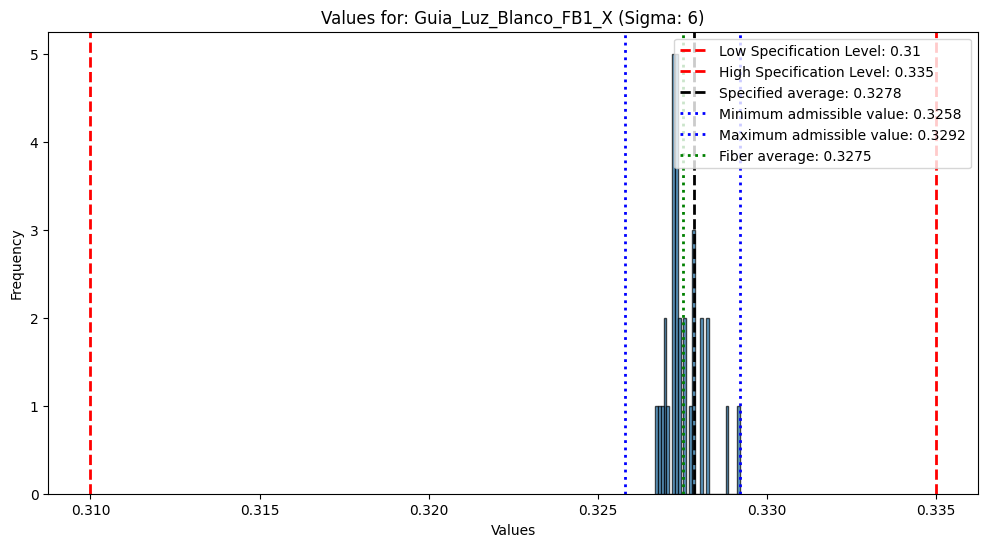

In [7]:
##Visualization of the capability values
label = fiber_selection.value
if auto_position.value is False:
    range_mapping = [0.05 - 0.0049 * (range_slider.value)]
    xrange = [mean_slider.value - range_mapping[0], mean_slider.value + range_mapping[0]]
else:
    range_mapping = None; xrange = None
display(HBox([fiber_selection, auto_position, mean_slider, range_slider]))
_ = plot_capability(MEAS_format, analysis_format, label, sigma_selector.value, xrange=xrange)

In [8]:
##Data export
name_xlsx = glob.tooling + "_capability_analysis_" + get_date() + ".xlsx"
name_pdf = glob.tooling + "_capability_visualization_" + get_date() + ".pdf"
name_data = glob.tooling + "_data_" + get_date() + ".pdf"
confirmation = input("Do you want to export the data? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.join(os.path.abspath("../a2_output"), name_xlsx)
    analysis_format.to_excel(output_filepath, index=True, header=True)
    _ = plot_to_pdf([MEAS_format, analysis_format], name_pdf, plot="Capability")
    df_to_pdf(DATA, name_data)
    #os.startfile('../a2_output/Target_with_limits.xlsx')
    print(f'Analysis data and visualizations exported inside:\n{os.path.split(output_filepath)[0]}')
else:
    print("Operation canceled.")

Operation canceled.


In [9]:
_ = plot_to_pdf([MEAS_format, analysis_format], name_pdf, plot="Capability")